In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

import gymnasium as gym
from gymnasium import spaces
import stable_baselines3 as sb

# from stable_baselines3.common.evaluation import evaluate_policy
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env

In [2]:
def RK4(fun, x, dt, t = 0, a = 0):

    k1 = fun(t,      x,         a)
    k2 = fun(t+dt/2, x+dt*k1/2, a)
    k3 = fun(t+dt/2, x+dt*k2/2, a)
    k4 = fun(t+dt,   x+dt*k3,   a)

    y = x + dt/6*(k1+2*k2+2*k3+k4)
    return y

In [42]:
l   = 200
g   = 980
gamma = .1
gammath = .1

def cart_evol(t, x, a = 0):
    vDot = a - gamma * x[1]
    xDot = x[1]
    return np.array([xDot, vDot])

def pend_evol(t, x, a = 0):
    thDotDot = (a * np.cos(x[0]) - g * np.sin(x[0]))/l - gammath * x[1]
    thDot    = x[1]
    return np.array([thDot, thDotDot])

def get_pos_pend(ang, x, L):
    return x - L*np.sin(ang), L*np.cos(ang)

4.037500000000032


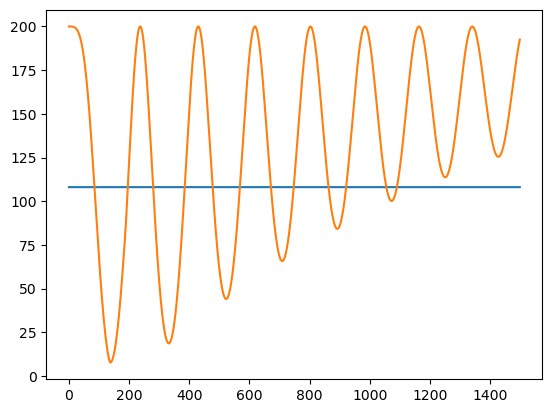

In [ ]:
''''
Cambios respecto a la version jugable
  - Adios elementos visuales
  - dt fijo en 8.5ms ~ dt para 120 fps
  - tecnicamente el eje Y apunta hacia abajo y el carro esta en 0 de y
  - puse una listita y un plot para ver q ande bien sin los elementos visuales
'''
crashed = []
ypendlist = []

rail_lengh = 1500
dt = 8.5/1000 # 10ms
target_th = 1
target_H = l*np.cos(target_th)
score = 0

actions = [-1,0,1]
th, thDot  = 0, 0
a, v, x = 0, 0, 750
pend_pos = get_pos_pend(th, x, l)
# Añado esto para poder tratar mejor las colisiones en los bordes
a_pend = a

action = 2
step = 0
while step < 1500: # unos 15s 
  if x < 100:
    crashed.append(-1)
    x, a = 100, -v/dt * .2
    a_pend = -v/dt * 1.2
    v = 0
  elif x > 1400:
    crashed.append(1)
    x, a = 1400, -v/dt * .2
    a_pend = -v/dt * 1.2
    v = 0
  else:
    crashed.append(0)
    a = actions[action] * 1000
    a_pend = a

  x, v = RK4(cart_evol, [x, v], dt, a = a)
  th, thDot = RK4(pend_evol, [th, thDot], dt, a = a_pend)
  
  pend_pos = get_pos_pend(th, x, l)
  ypendlist.append(pend_pos[1])

  if pend_pos[1] < target_H:
    score += dt
  
  step += 1

print(score)
plt.plot([target_H]*1500)
plt.plot(ypendlist)

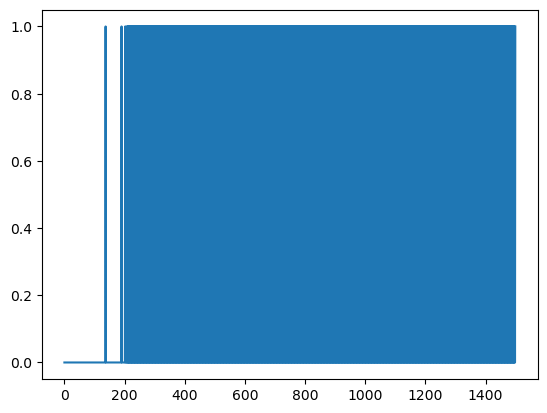

In [86]:
plt.plot(crashed)